In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd
import geopandas as gpd
from shapely.geometry import Polygon
from cmocean import cm
%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.6291181.datarmor0/parcels-502027/libparcels_random_009b5f43-4e2c-4b5c-88cc-193c43aeaa4e.so


In [2]:
from dask.distributed import Client, LocalCluster
if True:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=2)
else:    
    cluster = LocalCluster()
client = Client(cluster)

In [3]:
client

Client Scheduler: tcp://10.148.0.83:40528 Dashboard: http://10.148.0.83:8787/status,Cluster Workers: 14 Cores: 14 Memory: 223.58 GiB


---
## load data

In [4]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'
p = pa.parcels_output(root_dir+run_name, parquets=['time'])
df = p.df['time']
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,waterdepth
time,,,,,,,,,,
2011-11-15 00:00:00,39000000,57.853661,-178.856766,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
2011-11-15 01:00:00,39000000,57.845396,-178.861217,0.0,-0.000003,-2.249167e-06,0.921884,3.915445,32.918678,3749.076904
2011-11-15 02:00:00,39000000,57.838902,-178.874172,0.0,-0.000005,-1.382484e-06,0.987710,3.919090,32.916588,3749.076904
2011-11-15 03:00:00,39000000,57.835855,-178.893247,0.0,-0.000006,-1.862039e-07,0.826575,3.913553,32.917782,3749.076904
2011-11-15 04:00:00,39000000,57.836742,-178.913583,0.0,-0.000005,8.201220e-07,0.475389,3.898716,32.919697,3683.949951


In [5]:
df['2011-11-15 01:00:00'].compute().head()
# velocities have weird values
# tracers are ok

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,waterdepth
time,,,,,,,,,,
2011-11-15 01:00:00,39000000,57.845396,-178.861217,0.0,-0.000003,-2.249167e-06,0.921884,3.915445,32.918678,3749.076904
2011-11-15 01:00:00,39000001,58.451424,-178.884643,0.0,-0.000006,1.873800e-06,0.915702,4.343204,32.903275,3484.060059
2011-11-15 01:00:00,39000002,59.031884,-178.889452,0.0,-0.000006,-9.771594e-07,1.086879,4.494350,32.808506,3180.445068
2011-11-15 01:00:00,39000003,59.618245,-178.894018,0.0,-0.000004,4.713949e-07,1.106338,4.419613,32.772675,2107.854736
2011-11-15 01:00:00,39000004,60.200614,-178.904429,0.0,-0.000003,2.367990e-06,1.044295,4.406907,32.861530,434.964996


In [6]:
t_start = df.index.min().compute()
t_end = df.index.max().compute()
delta_t = (t_end - t_start)/pd.Timedelta('1D') # in days

print(t_start, t_end, delta_t)

2011-11-15 00:00:00 2012-11-09 01:00:00 360.0416666666667


### define bins

In [7]:
# geographical bins
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-60.,60., dl)

# temporal bins
#t_bins = pd.date_range(t_start, t_end, freq='1M')
t_bins = pd.date_range(t_start, t_end, freq='1MS') # starts at the beginning of each month
cut = lambda df, bins: pd.cut(df.index.to_series(), bins=bins)

In [8]:
df['lon'] = (df['lon']+180)%360 - 180
df['lon_cut'] = df['lon'].map_partitions(pd.cut, lon_bins)
df['lat_cut'] = df['lat'].map_partitions(pd.cut, lat_bins)
cut = lambda df, bins: pd.cut(df.index.to_series(), bins=bins)
df['time_cut'] = df.map_partitions(cut, t_bins)

In [9]:
df = df.persist()

### group by geographical area

In [10]:
def add_geodata(df):

    df['lon'] = df.apply(lambda r: r.name[0].mid, axis=1)
    df['lat'] = df.apply(lambda r: r.name[1].mid, axis=1)

    def build_polygon(r):
        lon0, lon1 = r.name[0].left, r.name[0].right
        lat0, lat1 = r.name[1].left, r.name[1].right
        return Polygon([[lon0, lat0],[lon1, lat0], [lon1, lat1], [lon0, lat1]])

    df['Coordinates'] = df.apply(build_polygon, axis=1)
    df = gpd.GeoDataFrame(df, geometry='Coordinates', crs='EPSG:4326')
    df['area'] = df.to_crs(crs = 'epsg:3857').area /1e6 / 1e4 # 100km^2 units
    
    return df

In [11]:
count = (df
         .groupby([df.lon_cut, df.lat_cut])
         .count()
         .compute()
         ['z'].rename('count')
         .to_frame()
        )

# normalize by time window length
count = count/delta_t
#
count = add_geodata(count)
count['density'] = count['count']/count['area']

ds_density = (count
              .drop(columns=['Coordinates'])
              .set_index(['lon', 'lat'])
              .to_xarray()
             )
ds_density

<xarray.Dataset>
Dimensions:  (lat: 119, lon: 359)
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 176.5 177.5 178.5
  * lat      (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 ... 55.5 56.5 57.5 58.5
Data variables:
    count    (lon, lat) float64 63.9 67.66 66.61 58.7 ... 48.25 59.66 51.68
    area     (lon, lat) float64 2.442 2.372 2.307 2.245 ... 2.245 2.307 2.372
    density  (lon, lat) float64 26.17 28.53 28.88 26.14 ... 21.49 25.87 21.79

# KE from spectra

In [17]:
E_Eulerian = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat_lon_bands_from_2Dbin_spectra.zarr'))
E_Eulerian = (E_Eulerian.rename({'E_SSUV':'E_Eulerian'}))
E_Eulerian

,Array,Chunk
Bytes,4.89 MiB,10.55 kiB
Shape,"(15, 359, 119)","(1, 45, 30)"
Count,481 Tasks,480 Chunks
Type,float64,numpy.ndarray


In [14]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])
E_lagrangian = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon_bands.zarr')
E_lagrangian = E_lagrangian.rename({'E':'E_Lagrangian'})
E_lagrangian = E_lagrangian.E_Lagrangian
E_lagrangian

<xarray.DataArray 'E_Lagrangian' (frequency_band: 15, lon_bins: 359, lat_bins: 119)>
dask.array<open_dataset-6419eef61746138f7a56ffae4aeafae2E, shape=(15, 359, 119), dtype=float64, chunksize=(1, 359, 119), chunktype=numpy.ndarray>
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5

In [18]:
from xhistogram.xarray import histogram

# 2D binned Depth
V = ["SSUV"]
T = ["T60"]

sub = 1
dl = 1.
lon = np.arange(-180.,180., dl)
lat = np.arange(-60., 60., dl)
    
for v in V:
    for t in T:
        
        # read data
        ds = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/spectra_%s_%s.zarr'%(v,t)))
        ds = ds.isel(i=slice(0,None,sub),j=slice(0,None,sub))
        #ds = ds.where(ds.Depth>500, drop=False)
        #ds = ds.load()
        
        # lat, lon binning
        ds['lon'] = 0*ds.face+ds.XC
        ds['lat'] = 0*ds.face+ds.YC
        N = histogram(
                      ds.lon.load(), ds.lat.load(), 
                      bins=[lon, lat], 
                      dim=['i', 'j', 'face'], 
                      block_size=None
                     )

        E = histogram(
                      ds.lon.load(), ds.lat.load(),
                      bins=[lon, lat], 
                      weights= ds.Depth.load(), 
                      dim=['i', 'j', 'face'], 
                      block_size=None
                     )
        
        # get binned results
        Depth_bin = (E/N).rename('E_depth').rename({'lon_bin': 'lon_bins','lat_bin': 'lat_bins'})        

In [19]:
ds_E = xr.merge([E_Eulerian,E_lagrangian,Depth_bin])
ds_E

<xarray.Dataset>
Dimensions:         (frequency_band: 15, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_Eulerian      (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 45, 30), meta=np.ndarray>
    E_Lagrangian    (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 359, 119), meta=np.ndarray>
    E_depth         (lon_bins, lat_bins) float64 4.548e+03 ... 3.74e+03

______________
# Together

In [20]:
ds_all = xr.merge([ds_E,ds_density.rename({'lat':'lat_bins','lon':'lon_bins'})])
ds_all

<xarray.Dataset>
Dimensions:         (frequency_band: 15, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_Eulerian      (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 45, 30), meta=np.ndarray>
    E_Lagrangian    (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 359, 119), meta=np.ndarray>
    E_depth         (lon_bins, lat_bins) float64 4.548e+03 ... 3.74e+03
    count           (lon_bins, lat_bins) float64 63.9 67.66 ... 59.66 51.68
    area            (lon_bins, lat_bins) float64 2.442 2.372 ... 2.307 2.372
    density         (lon_bins, lat_bins) float64 26.17 28.53 ... 25.87 21.79

Text(0.5, 0, 'Low-freq KE (Eulerian)')

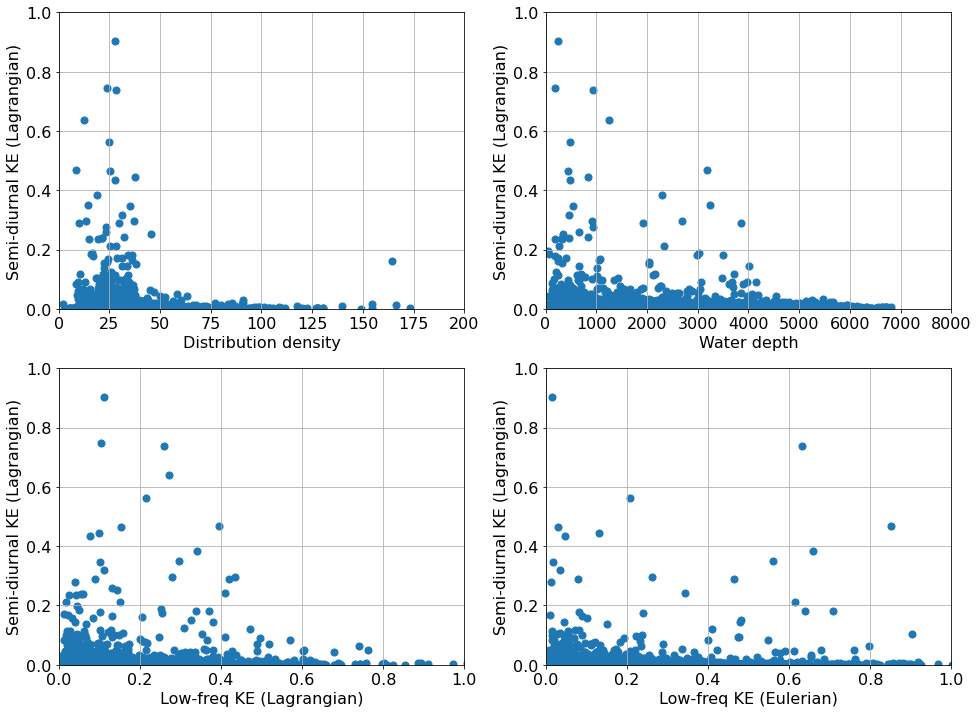

In [21]:
upper_limit = 0.2
font_size=16

fig, ax = plt.subplots(1,1,figsize=(16,12))
ax = plt.subplot(221)
ax.scatter( ds_all.density, 
            ds_all.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1'), 
            s=50)
ax.grid(); 
ax.set_xlim(0.,200); 
ax.set_ylim(0.,1)
ax.set_title('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Semi-diurnal KE (Lagrangian)',fontsize=font_size)
ax.set_xlabel('Distribution density',fontsize=font_size)

ax = plt.subplot(222)
ax.scatter( ds_all.E_depth, 
            ds_all.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1'), 
            s=50)
ax.grid(); 
ax.set_xlim(0.,8000); 
ax.set_ylim(0.,1)
ax.set_title('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Semi-diurnal KE (Lagrangian)',fontsize=font_size)
ax.set_xlabel('Water depth',fontsize=font_size)

ax = plt.subplot(223)
ax.scatter( ds_all.E_Lagrangian.sel(frequency_band='low'),
            ds_all.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1'), 
            s=50)
ax.grid(); 
ax.set_xlim(0.,1); 
ax.set_ylim(0.,1)
ax.set_title('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Semi-diurnal KE (Lagrangian)',fontsize=font_size)
ax.set_xlabel('Low-freq KE (Lagrangian)',fontsize=font_size)

ax = plt.subplot(224)
ax.scatter( ds_all.E_Eulerian.sel(frequency_band='low'),
            ds_all.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1'), 
            s=50)
ax.grid(); 
ax.set_xlim(0.,1); 
ax.set_ylim(0.,1)
ax.set_title('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Semi-diurnal KE (Lagrangian)',fontsize=font_size)
ax.set_xlabel('Low-freq KE (Eulerian)',fontsize=font_size)

Text(0.5, 0, 'Low-freq KE (Eulerian)')

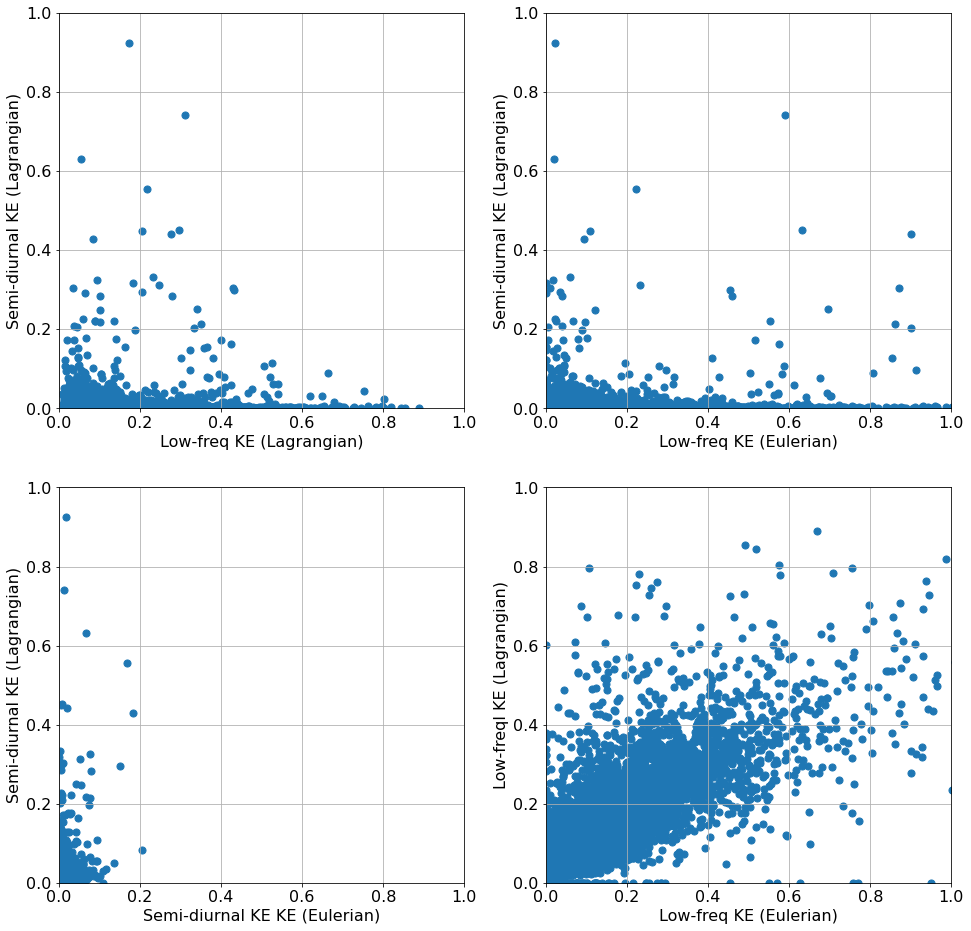

In [23]:
upper_limit = 0.2
font_size=16

fig, ax = plt.subplots(1,1,figsize=(16,16))
ax = plt.subplot(221)
ax.scatter( ds_all.E_Lagrangian.sel(frequency_band='low'),
            ds_all.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1'), 
            s=50)
ax.grid(); 
ax.set_xlim(0.,1); 
ax.set_ylim(0.,1)
ax.set_title('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Semi-diurnal KE (Lagrangian)',fontsize=font_size)
ax.set_xlabel('Low-freq KE (Lagrangian)',fontsize=font_size)

ax = plt.subplot(222)
ax.scatter( ds_all.E_Eulerian.sel(frequency_band='low'),
            ds_all.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1'), 
            s=50)
ax.grid(); 
ax.set_xlim(0.,1); 
ax.set_ylim(0.,1)
ax.set_title('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Semi-diurnal KE (Lagrangian)',fontsize=font_size)
ax.set_xlabel('Low-freq KE (Eulerian)',fontsize=font_size)

ax = plt.subplot(223)
ax.scatter( ds_all.E_Eulerian.sel(frequency_band='semidiurnal_0dot1'),
            ds_all.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1'), 
            s=50)
ax.grid(); 
ax.set_xlim(0.,1); 
ax.set_ylim(0.,1)
ax.set_title('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Semi-diurnal KE (Lagrangian)',fontsize=font_size)
ax.set_xlabel('Semi-diurnal KE KE (Eulerian)',fontsize=font_size)

ax = plt.subplot(224)
ax.scatter( ds_all.E_Eulerian.sel(frequency_band='low'),
            ds_all.E_Lagrangian.sel(frequency_band='low'), 
            s=50)
ax.grid(); 
ax.set_xlim(0.,1); 
ax.set_ylim(0.,1)
ax.set_title('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('Low-freql KE (Lagrangian)',fontsize=font_size)
ax.set_xlabel('Low-freq KE (Eulerian)',fontsize=font_size)

Text(0.5, 1.0, 'Semi-diurnal KE (Lagrangian)')

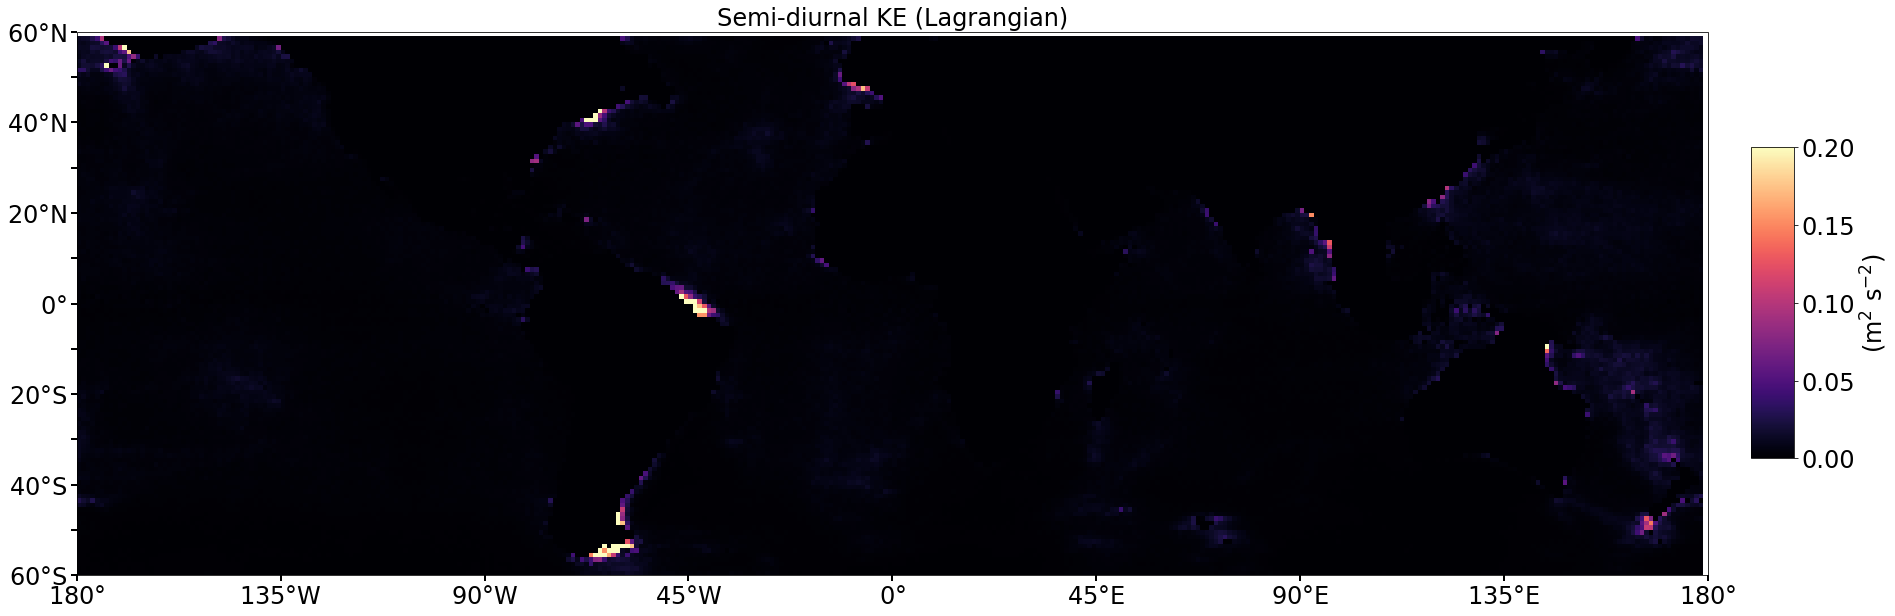

In [40]:
font_size = 24

figsize = (30,10)

crs = ccrs.PlateCarree(central_longitude=0)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=crs)

im = ds_all.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1').plot(x='lon_bins', 
                            y='lat_bins',
                            cmap='magma', vmin=0,vmax=0.2,
                            ax=ax, add_colorbar=False,
                            transform=ccrs.PlateCarree(),
                           )
cax = plt.axes([0.91, 0.2875, 0.02, 0.432])
cb = plt.colorbar(im, cax=cax)
cb.ax.set_ylabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
cb.ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)
ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
ax.set_xticklabels(['$180\degree$','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
ax.tick_params(direction='out', length=6, width=2)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Semi-diurnal KE (Lagrangian)',fontsize=font_size)

Text(0.5, 1.0, 'Average number of floats per 100km^2 and per day')

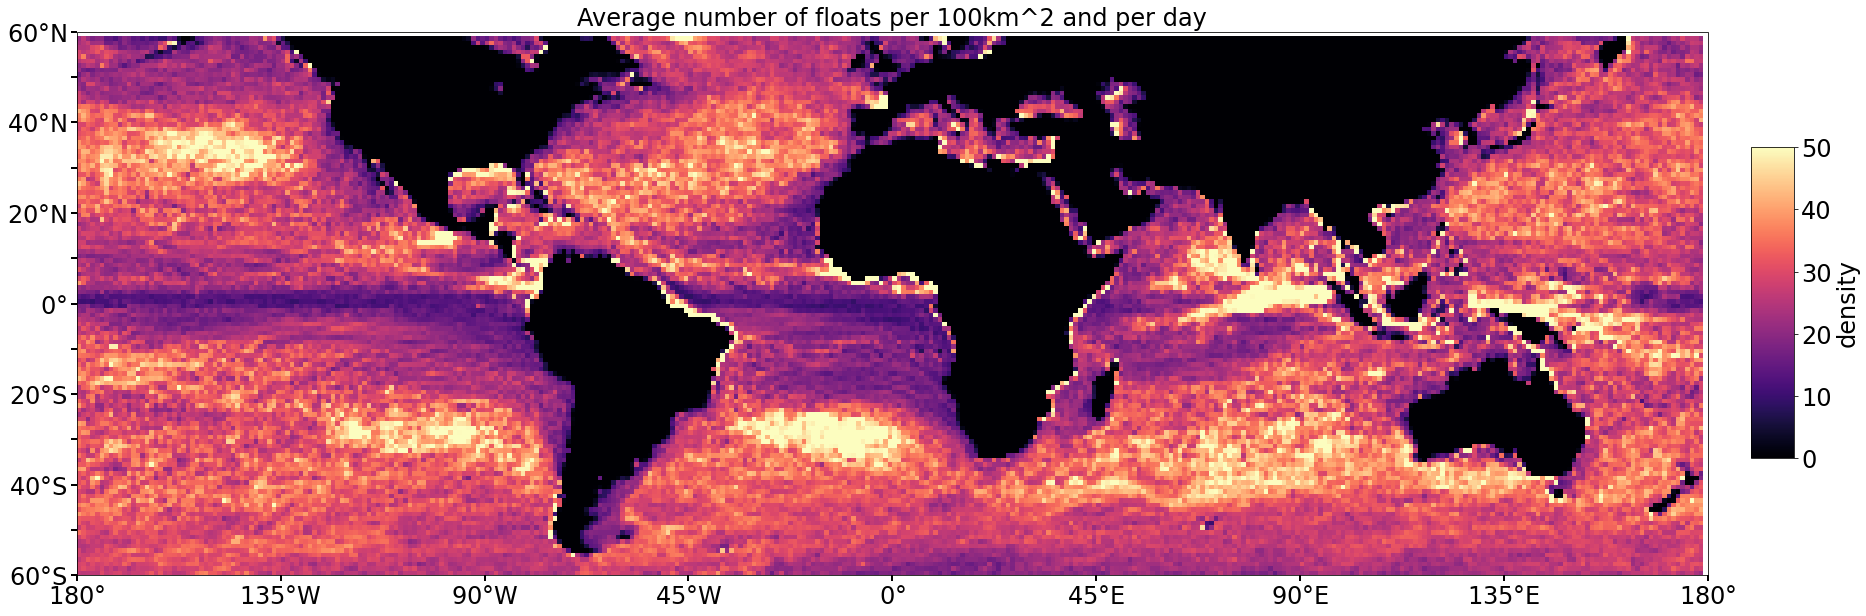

In [22]:
font_size = 24

figsize = (30,10)

crs = ccrs.PlateCarree(central_longitude=0)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=crs)

im = ds_all['density'].plot(x='lon_bins', 
                            y='lat_bins',
                            vmax=50,
                            cmap='magma',
                            ax=ax, add_colorbar=False,
                            transform=ccrs.PlateCarree(),
                           )
cax = plt.axes([0.91, 0.2875, 0.02, 0.432])
cb = plt.colorbar(im, cax=cax, ticks=[0, 10, 20, 30, 40, 50])
cb.ax.set_ylabel('density',fontsize=font_size)
cb.ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)
ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
ax.set_xticklabels(['$180\degree$','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
ax.tick_params(direction='out', length=6, width=2)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Average number of floats per 100km^2 and per day',fontsize=font_size)

Text(0.5, 1.0, 'Average number of floats per 100km^2 and per day')

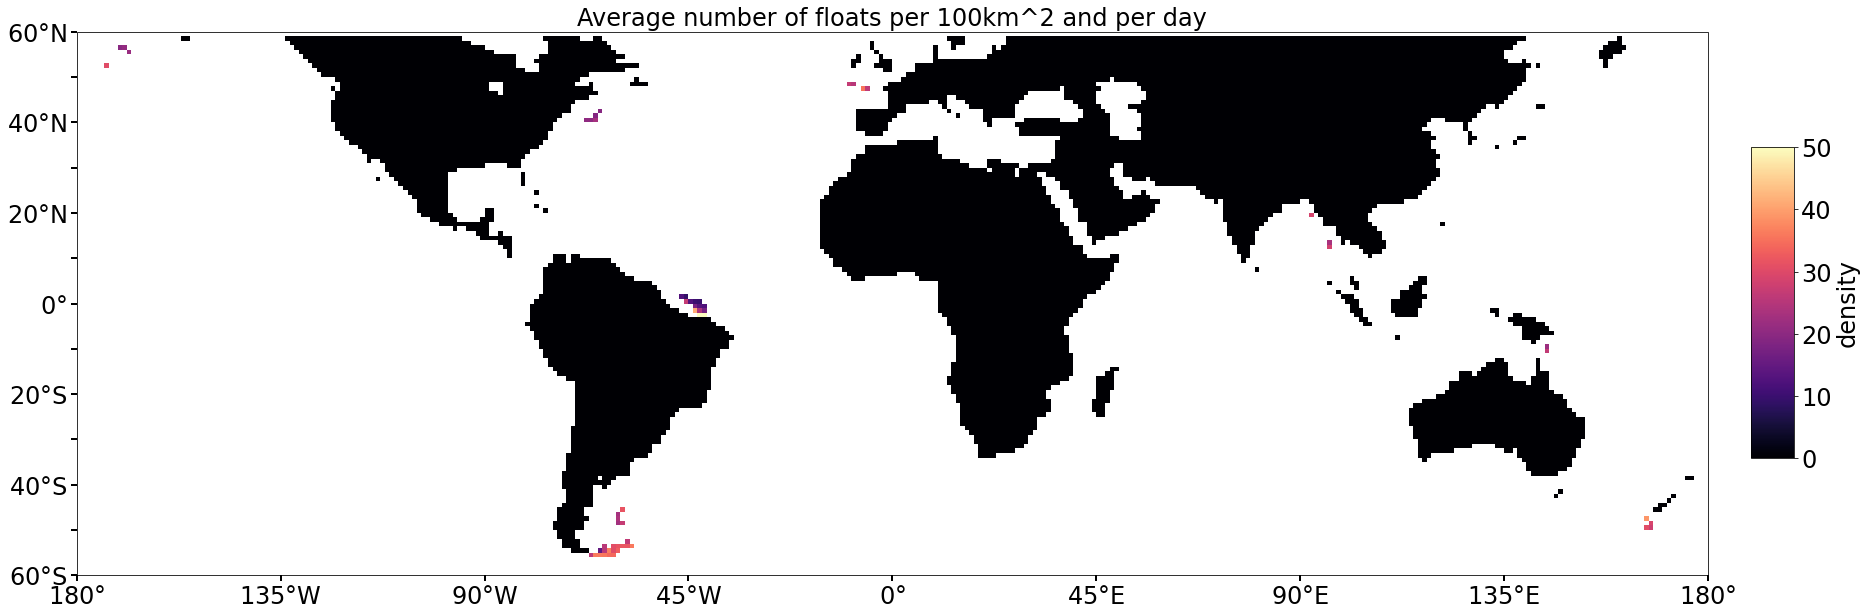

In [36]:
font_size = 24

figsize = (30,10)
crs = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=crs)
im = ds_all['density'].where( (ds_all.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1')>0.1)| (ds_all['density']==0) ).plot(x='lon_bins', 
                 y='lat_bins',
                 vmax=50,
                 cmap='magma',
                 ax=ax, add_colorbar=False,
                 transform=ccrs.PlateCarree(),
                )
cax = plt.axes([0.91, 0.2875, 0.02, 0.432])
cb = plt.colorbar(im, cax=cax, ticks=[0, 10, 20, 30, 40, 50])
cb.ax.set_ylabel('density',fontsize=font_size)
cb.ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)
ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
ax.set_xticklabels(['$180\degree$','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
ax.tick_params(direction='out', length=6, width=2)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Average number of floats per 100km^2 and per day',fontsize=font_size)

Text(0.5, 1.0, 'Average number of floats per 100km^2 and per day')

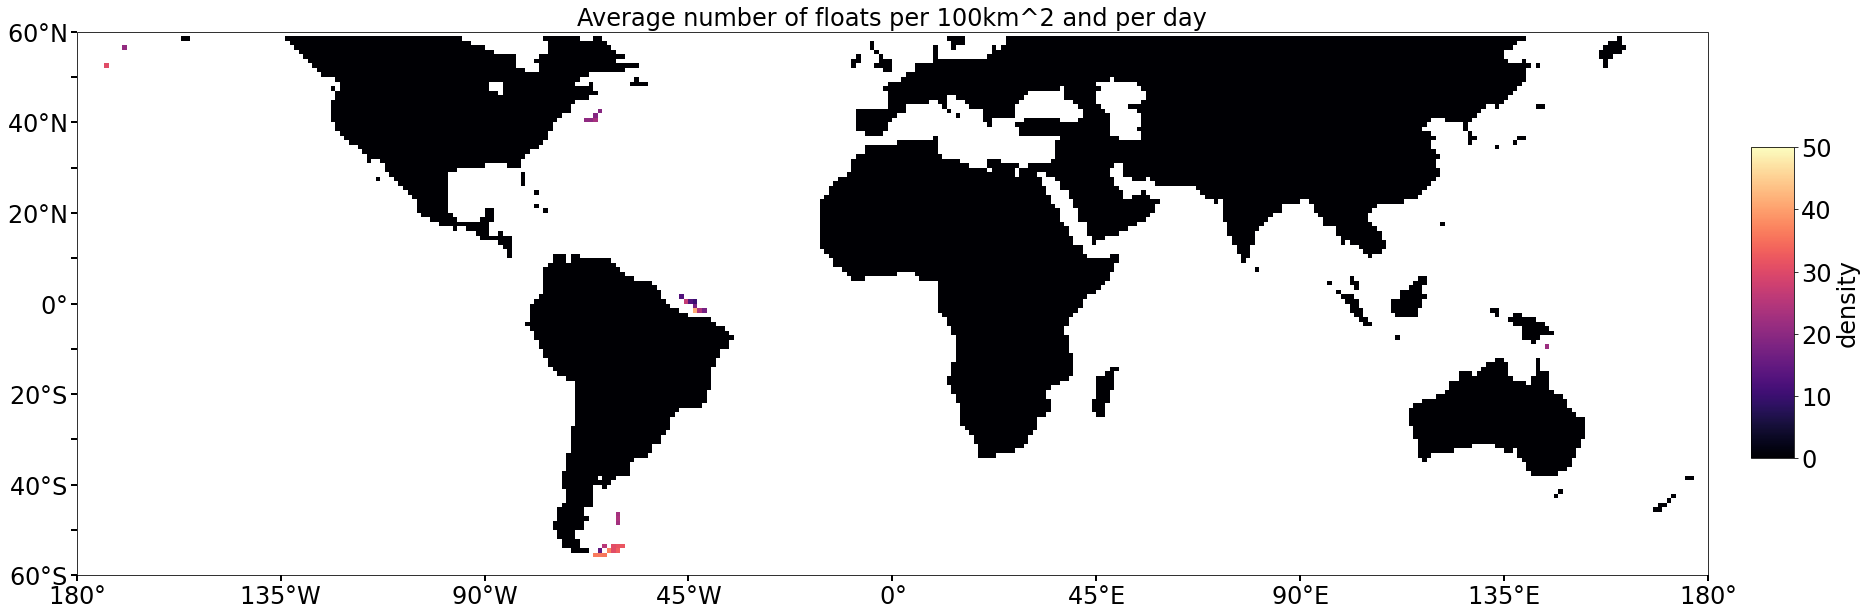

In [37]:
font_size = 24

figsize = (30,10)
crs = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=crs)
im = ds_all['density'].where( (ds_all.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1')>0.2)| (ds_all['density']==0)  ).plot(x='lon_bins', 
                 y='lat_bins',
                 vmax=50,
                 cmap='magma',
                 ax=ax, add_colorbar=False,
                 transform=ccrs.PlateCarree(),
                )
cax = plt.axes([0.91, 0.2875, 0.02, 0.432])
cb = plt.colorbar(im, cax=cax, ticks=[0, 10, 20, 30, 40, 50])
cb.ax.set_ylabel('density',fontsize=font_size)
cb.ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)
ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
ax.set_xticklabels(['$180\degree$','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
ax.tick_params(direction='out', length=6, width=2)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Average number of floats per 100km^2 and per day',fontsize=font_size)

Text(0.5, 1.0, 'Average number of floats per 100km^2 and per day')

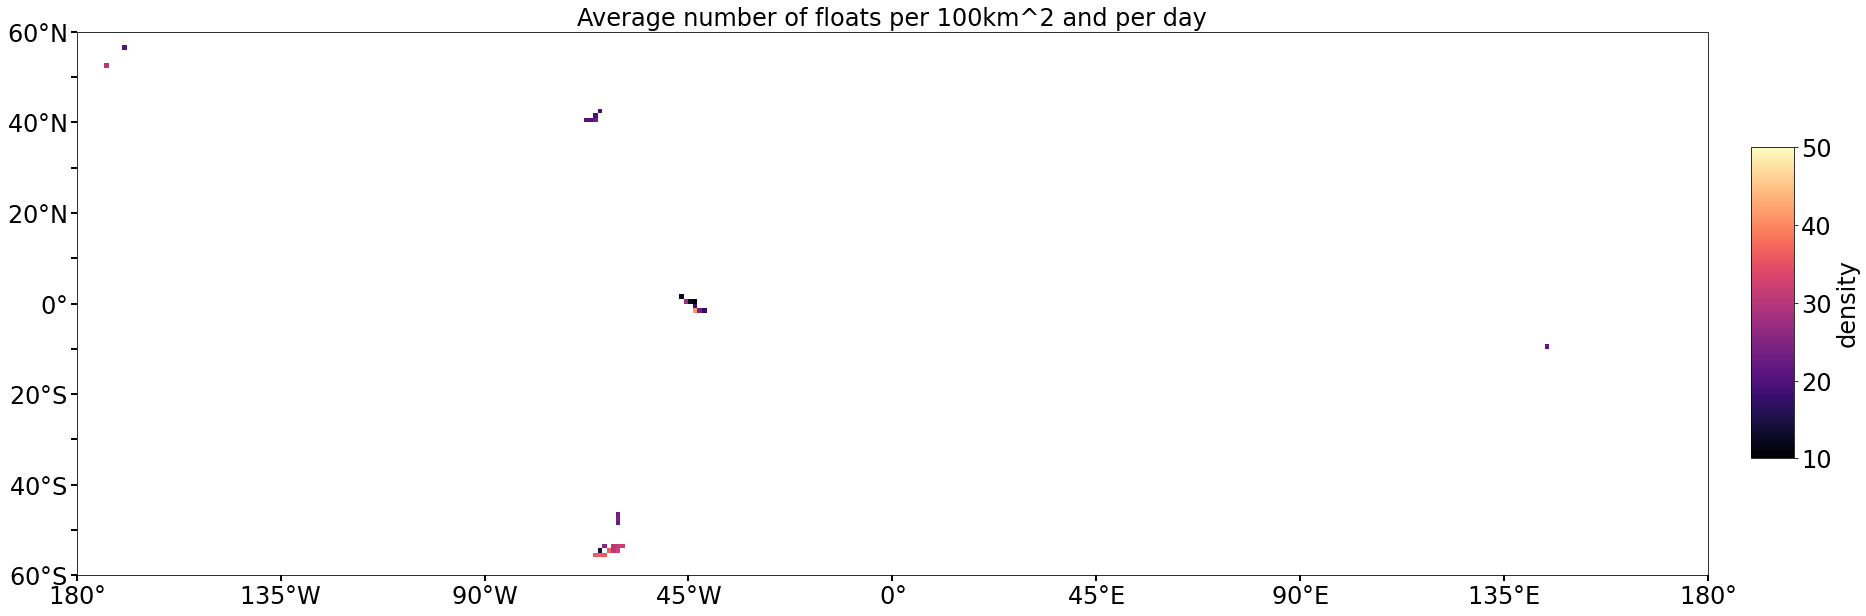

In [25]:
font_size = 24

figsize = (30,10)
crs = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=crs)
im = ds_all['density'].where(ds_all.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1')>0.2).plot(x='lon_bins', 
                 y='lat_bins',
                 vmax=50,
                 cmap='magma',
                 ax=ax, add_colorbar=False,
                 transform=ccrs.PlateCarree(),
                )
cax = plt.axes([0.91, 0.2875, 0.02, 0.432])
cb = plt.colorbar(im, cax=cax, ticks=[0, 10, 20, 30, 40, 50])
cb.ax.set_ylabel('density',fontsize=font_size)
cb.ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)
ax.set_xticks([-180, -135, -90, -45, 0, 45,  90, 135, 180])
ax.set_xticklabels(['$180\degree$','$135\degree$W','$90\degree$W','$45\degree$W','$0\degree$','$45\degree$E','$90\degree$E','$135\degree$E','$180\degree$'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60])
ax.set_yticklabels(['$60\degree$S','','$40\degree$S','','$20\degree$S','','$0\degree$','','$20\degree$N','','$40\degree$N','','$60\degree$N'])
ax.tick_params(direction='out', length=6, width=2)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('Average number of floats per 100km^2 and per day',fontsize=font_size)

# Semidiurnal band

______________
## lat*lon maps

In [4]:
E = '/home/datawork-lops-osi/equinox/mit4320/diags'
L = '/home/datawork-lops-osi/equinox/mit4320/parcels/global_extra_T365j_dt1j_dij50/diagnostics'

In [5]:
E_Eulerian = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat_lon_bands_from_2Dbin_spectra.zarr'))
E_Eulerian = (E_Eulerian.rename({'E_SSUV':'E_Eulerian'}))
E_Eulerian

<xarray.Dataset>
Dimensions:         (frequency_band: 14, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_Eulerian      (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 45, 30), meta=np.ndarray>

In [6]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])
E_lagrangian = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon_bands.zarr')
E_lagrangian = E_lagrangian.rename({'E':'E_Lagrangian'})
E_lagrangian = E_lagrangian.E_Lagrangian
E_lagrangian

<xarray.DataArray 'E_Lagrangian' (frequency_band: 14, lon_bins: 359, lat_bins: 119)>
dask.array<open_dataset-04919c09b9b32d84139c7f5300a1e6ccE, shape=(14, 359, 119), dtype=float64, chunksize=(1, 359, 60), chunktype=numpy.ndarray>
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5

In [7]:
# 2D binned Depth
V = ["SSUV"]
T = ["T60"]

sub = 1
dl = 1.
lon = np.arange(-180.,180., dl)
lat = np.arange(-60., 60., dl)
    
for v in V:
    for t in T:
        
        # read data
        ds = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/spectra_%s_%s.zarr'%(v,t)))
        ds = ds.isel(i=slice(0,None,sub),j=slice(0,None,sub))
        #ds = ds.where(ds.Depth>500, drop=False)
        #ds = ds.load()
        
        # lat, lon binning
        ds['lon'] = 0*ds.face+ds.XC
        ds['lat'] = 0*ds.face+ds.YC
        N = histogram(
                      ds.lon.load(), ds.lat.load(), 
                      bins=[lon, lat], 
                      dim=['i', 'j', 'face'], 
                      block_size=None
                     )

        E = histogram(
                      ds.lon.load(), ds.lat.load(),
                      bins=[lon, lat], 
                      weights= ds.Depth.load(), 
                      dim=['i', 'j', 'face'], 
                      block_size=None
                     )
        
        # get binned results
        Depth_bin = (E/N).rename('E_depth').rename({'lon_bin': 'lon_bins','lat_bin': 'lat_bins'})        

In [8]:
ds_E = xr.merge([E_Eulerian,E_lagrangian,Depth_bin])
ds_E

<xarray.Dataset>
Dimensions:         (frequency_band: 14, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_Eulerian      (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 45, 30), meta=np.ndarray>
    E_Lagrangian    (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 359, 60), meta=np.ndarray>
    E_depth         (lon_bins, lat_bins) float64 4.548e+03 ... 3.74e+03

Text(0.5, 1.0, '')

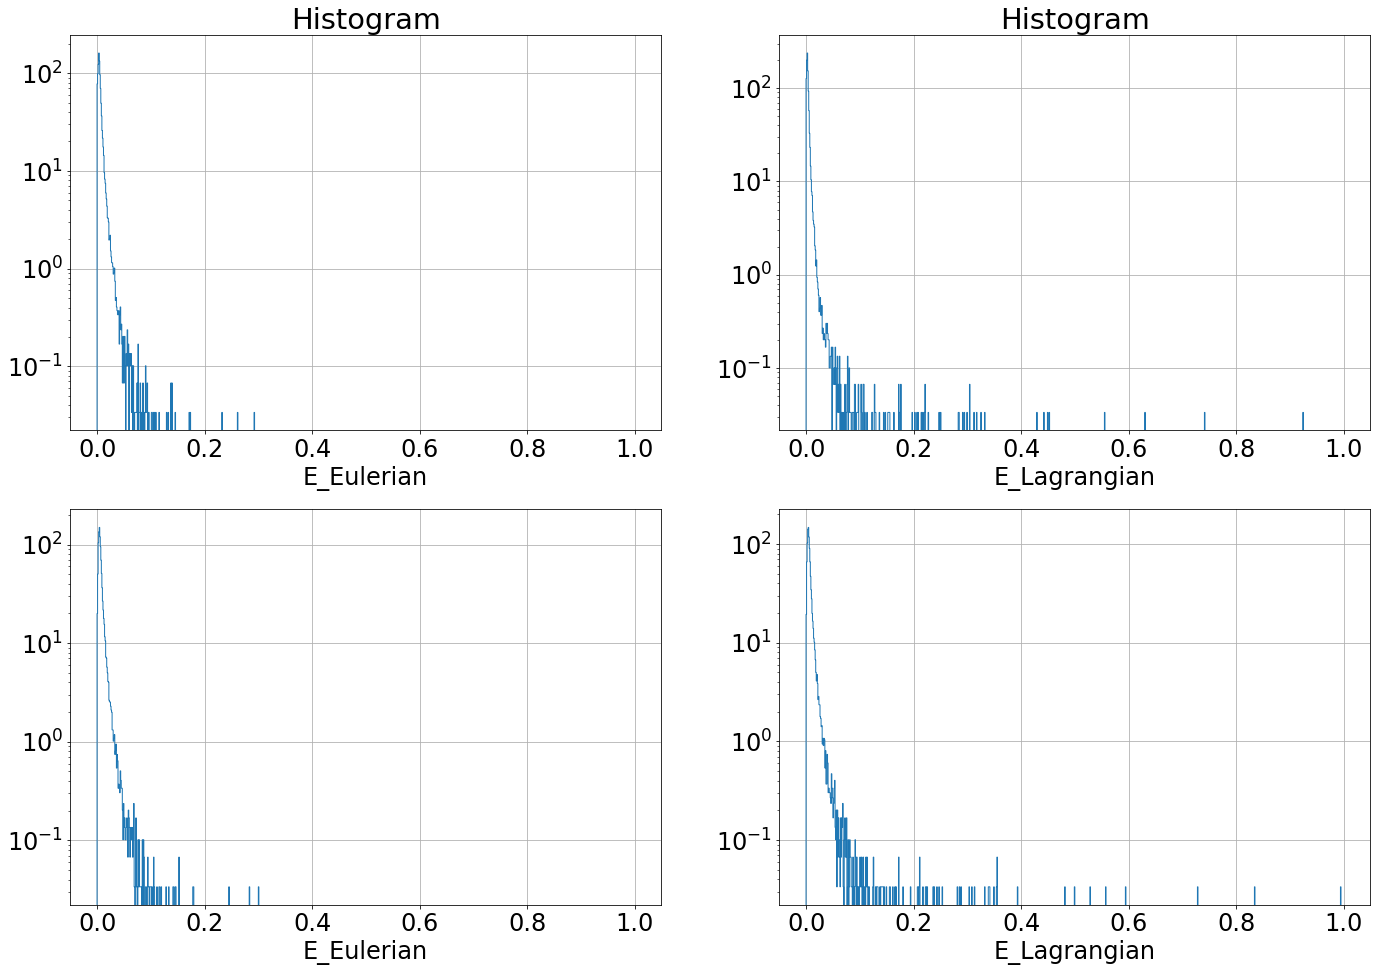

In [31]:

plt.rc('font', size=24) 
font_size=24

fig, ax = plt.subplots(figsize=(36,16))

ax = plt.subplot(231)
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1').plot.hist(bins=np.arange(0,1,1e-3),density=True, log=True, histtype='step')
ax.grid()
#ax.set_xlim([-3e-8,3e-8])
#ax.set_ylim([0.,1])
#ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
#ax.set_title('Winter',fontsize=font_size)
#ax.set_ylabel('Cumulative dist. func.',fontsize=font_size)
#ax.set_xlabel('$\Pi_{\omega}(5d)$ (m$^2$ s$^{-3}$)',fontsize=font_size)
#ax.tick_params(labelsize=font_size)

ax = plt.subplot(232)
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1').plot.hist(bins=np.arange(0,1,1e-3),density=True, log=True, histtype='step')
ax.grid()
#ax.set_title('',fontsize=font_size)

ax = plt.subplot(234)
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot4').plot.hist(bins=np.arange(0,1,1e-3),density=True, log=True, histtype='step')
ax.grid()
ax.set_title('',fontsize=font_size)

ax = plt.subplot(235)
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4').plot.hist(bins=np.arange(0,1,1e-3),density=True, log=True, histtype='step')
ax.grid()
ax.set_title('',fontsize=font_size)


In [32]:
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1').max()

<xarray.DataArray 'E_Lagrangian' ()>
array(0.9248541)
Coordinates:
    frequency_band  <U17 'semidiurnal_0dot1'

In [33]:
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4').max()

<xarray.DataArray 'E_Lagrangian' ()>
array(0.99437331)
Coordinates:
    frequency_band  <U17 'semidiurnal_0dot4'

Text(0.5, 0, '')

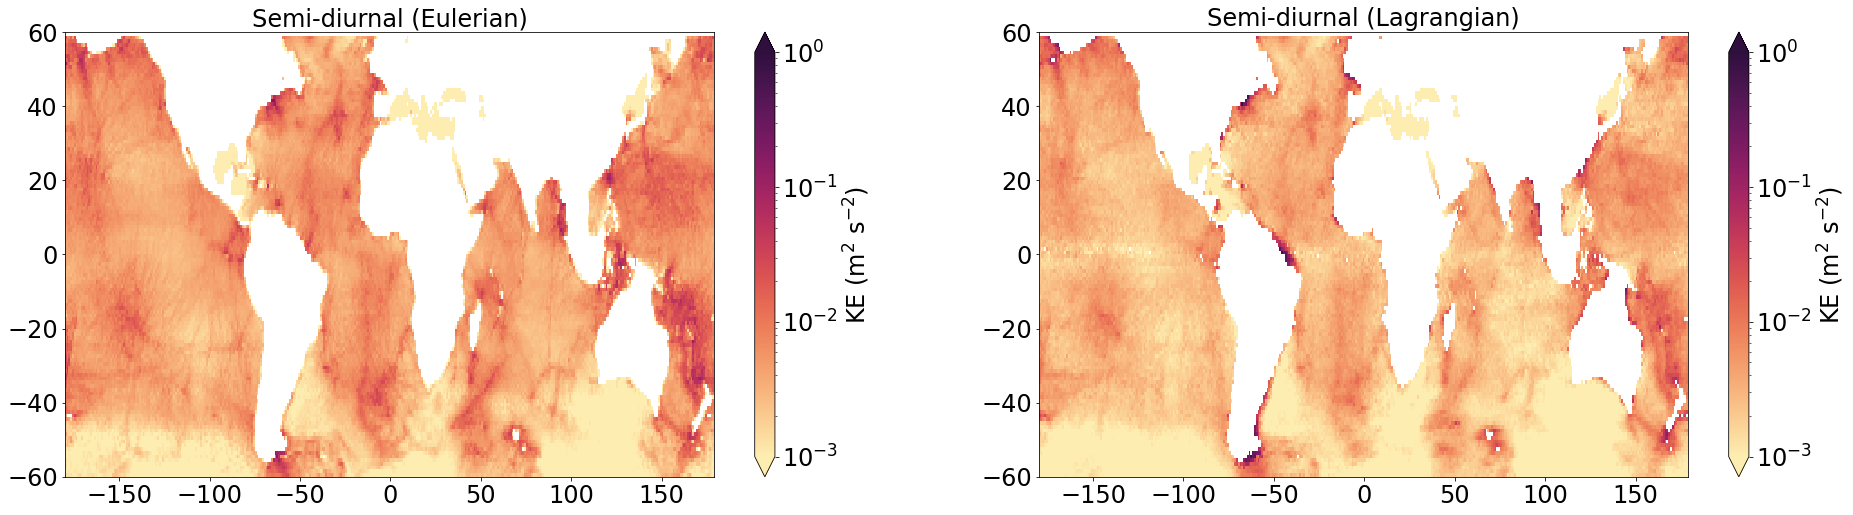

In [19]:
# bandwidth +-0.1
font_size = 24
fig, ax = plt.subplots(figsize=(32,18))

ax = plt.subplot(221)
cax=(ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e0), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(222)
cax=(ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1')).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e0), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('KE (m$^2$ s$^{-2}$)', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

Text(0.5, 0, '')

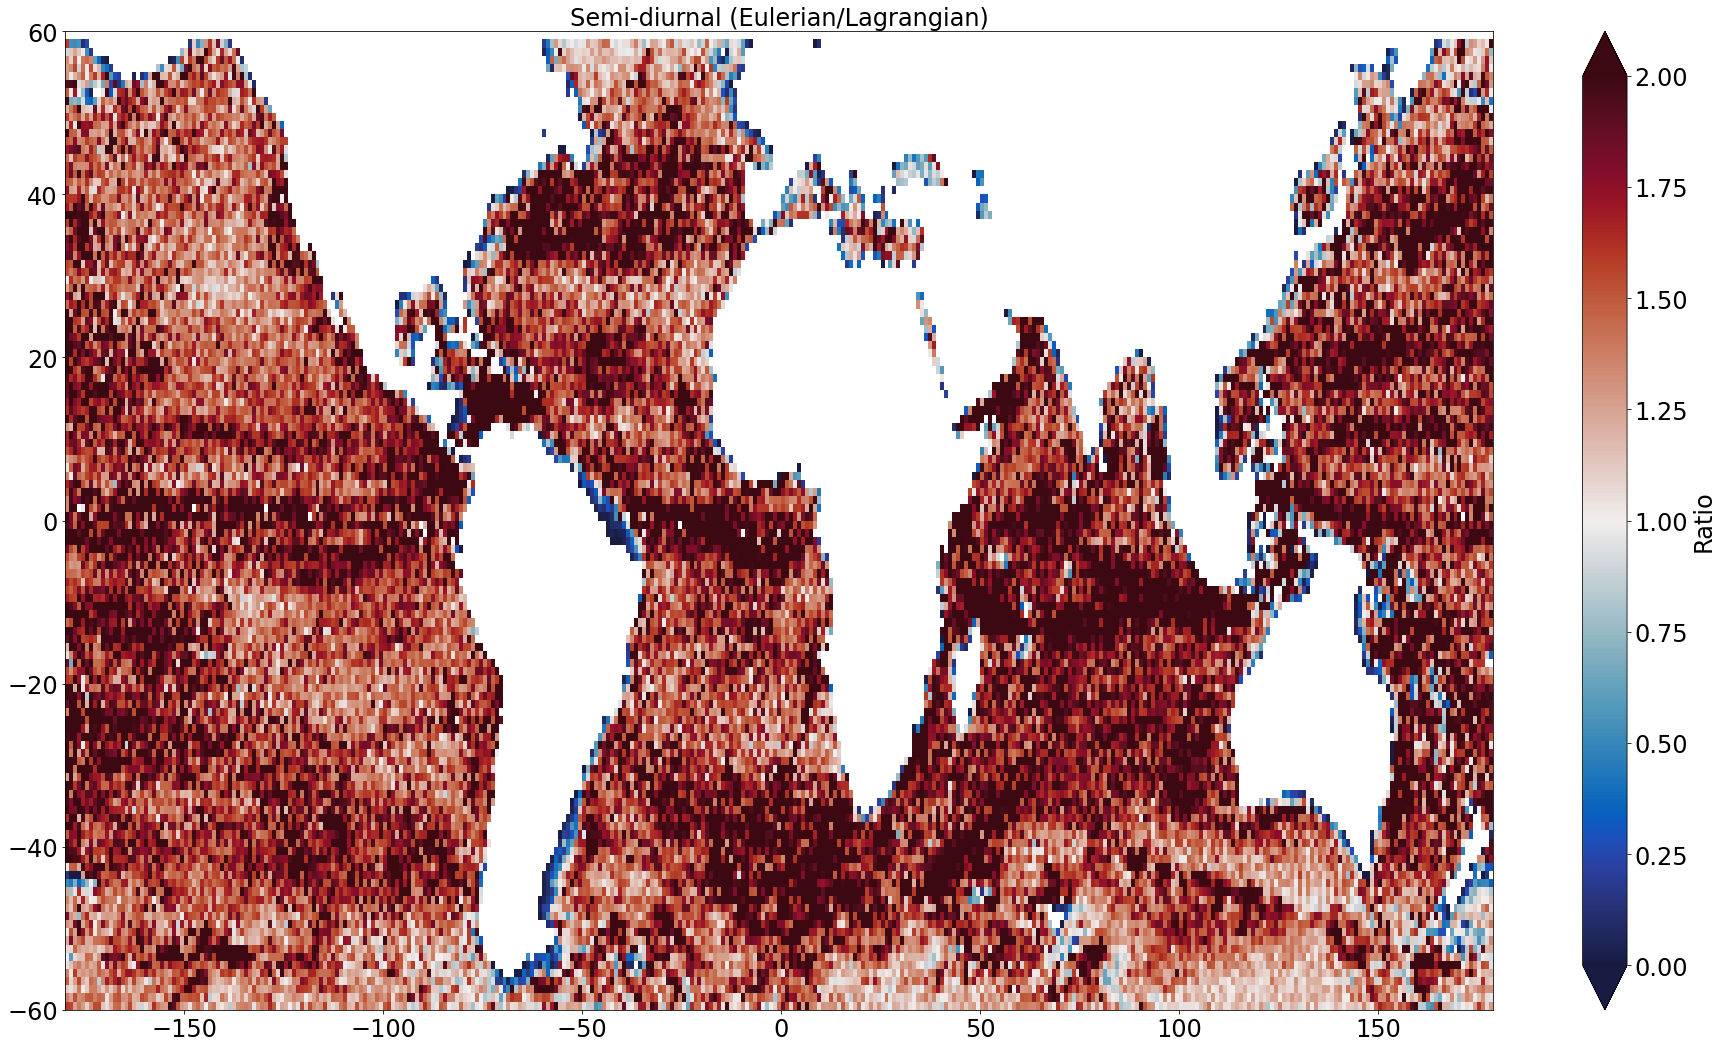

In [9]:
# bandwidth +-0.1
font_size = 24
fig, ax = plt.subplots(figsize=(32,18))


ax = plt.subplot(111)
cax = (E_Eulerian.E_SSUV.sel(frequency_band='semidiurnal_0dot1')/E_lagrangian.sel(frequency_band='semidiurnal_0dot1')).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, vmin=0, vmax=2, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)


Text(0.5, 0, '')

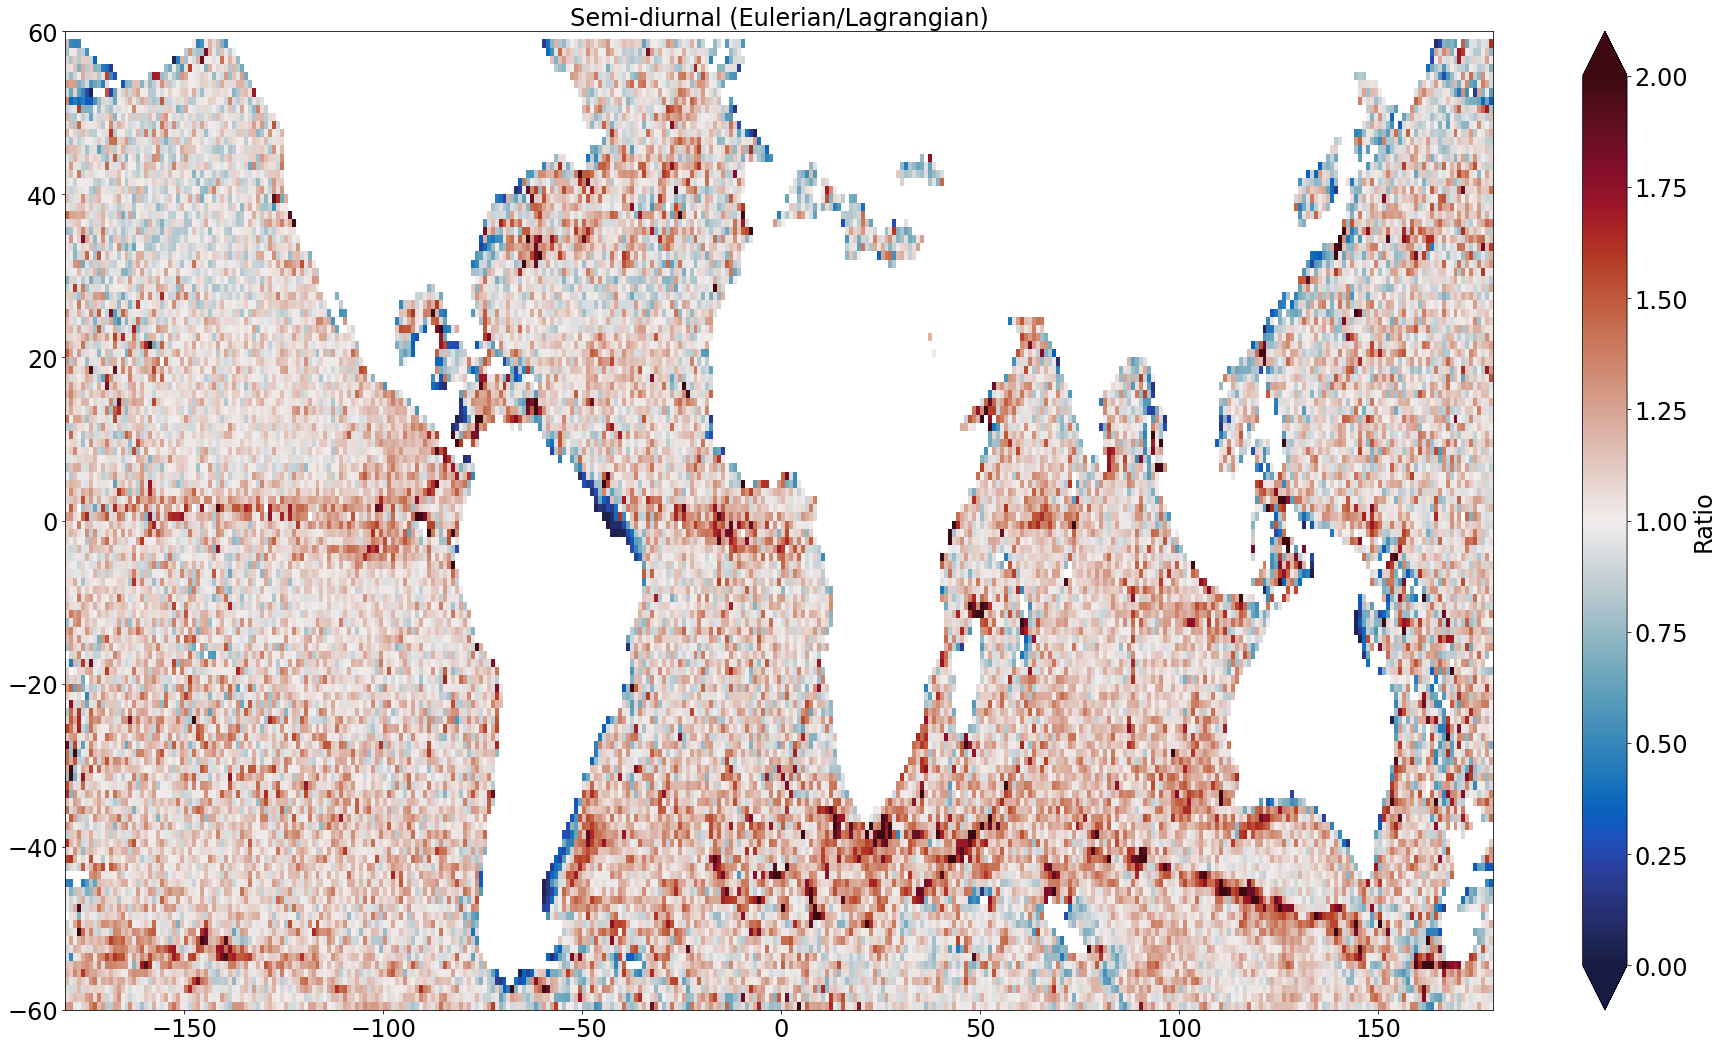

In [42]:
# bandwidth +-0.4
font_size = 24
fig, ax = plt.subplots(figsize=(32,18))

ax = plt.subplot(111)
cax = (ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot4')/ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4')).where(ds_E.E_depth>1000).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, vmin=0, vmax=2, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Ratio', fontsize=font_size)
#ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_title('Semi-diurnal (Eulerian/Lagrangian)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

In [64]:
ds_E

<xarray.Dataset>
Dimensions:         (frequency_band: 14, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_Eulerian      (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(7, 180, 60), meta=np.ndarray>
    E_Lagrangian    (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 359, 60), meta=np.ndarray>
    E_depth         (lon_bins, lat_bins) float64 4.548e+03 ... 3.74e+03

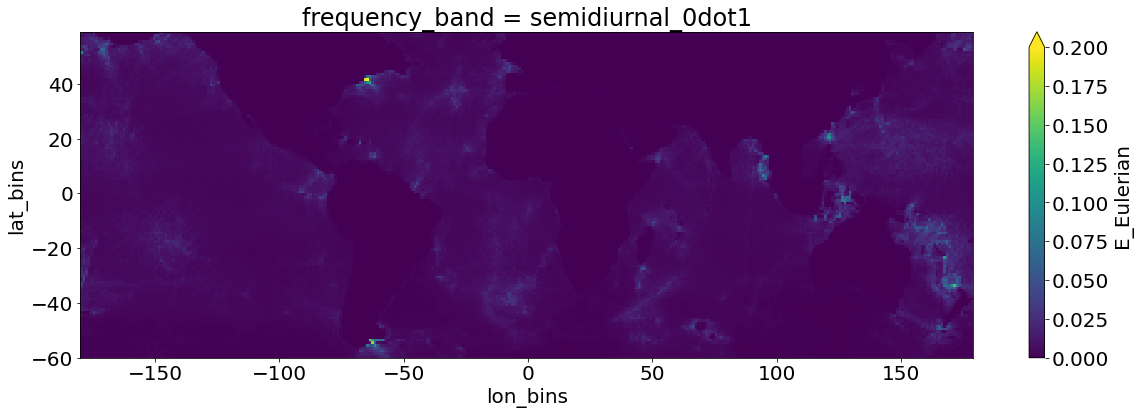

In [36]:
fig, ax = plt.subplots(figsize=(20,6))
ax = plt.subplot(111)
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1').plot(x='lon_bins', vmin=0,vmax=0.2)

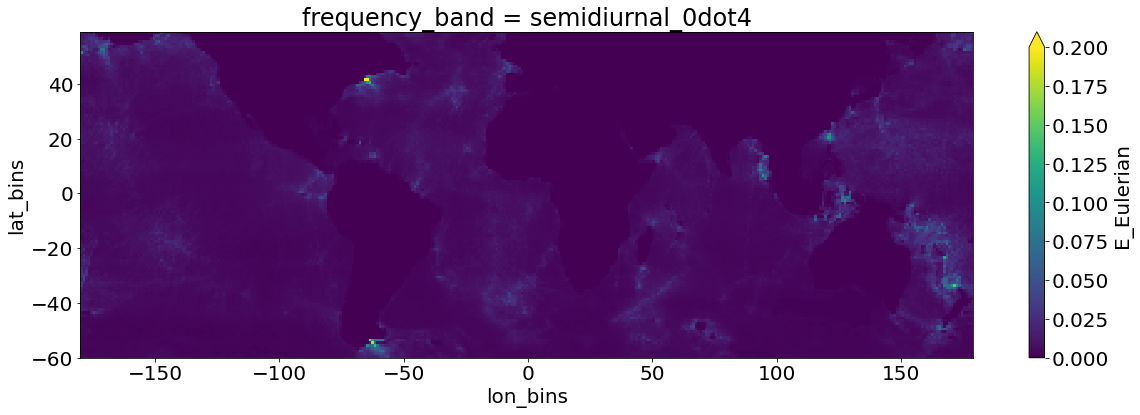

In [31]:
fig, ax = plt.subplots(figsize=(20,6))
ax = plt.subplot(111)
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot4').plot(x='lon_bins', vmin=0,vmax=0.2)

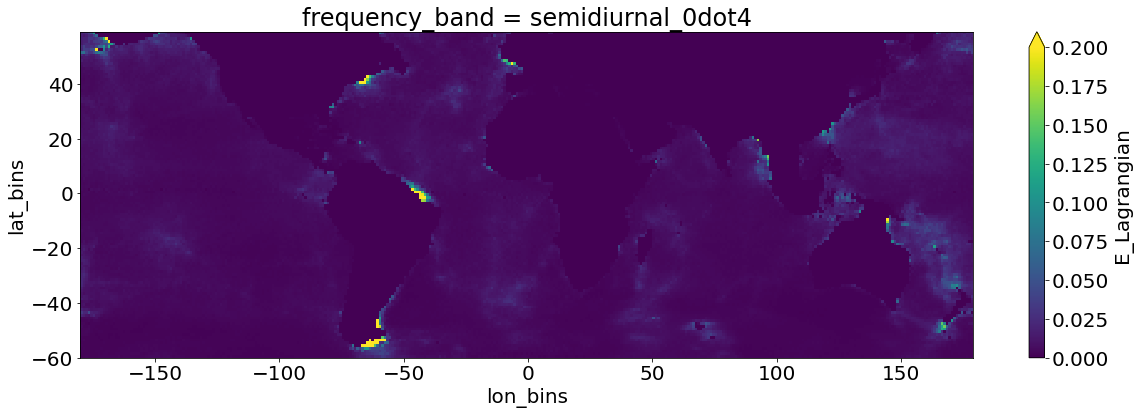

In [32]:
fig, ax = plt.subplots(figsize=(20,6))
ax = plt.subplot(111)
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4').plot(x='lon_bins', vmin=0,vmax=0.2)

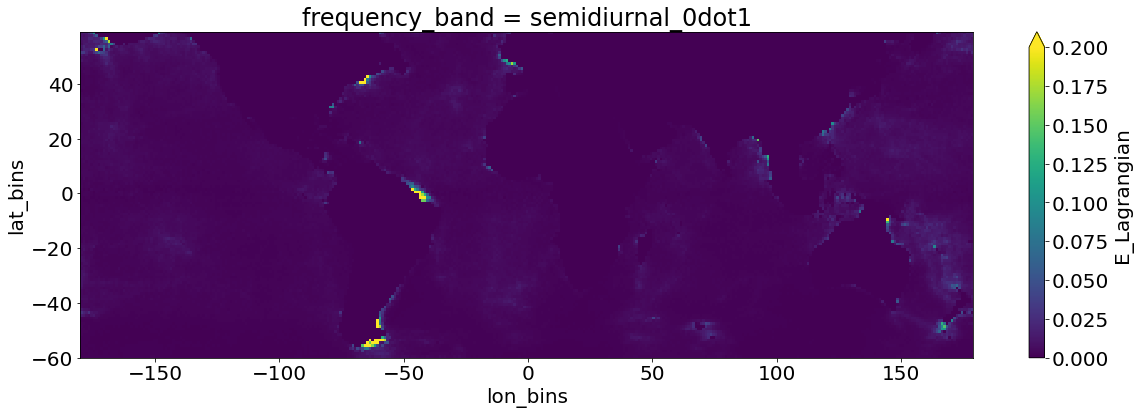

In [35]:
fig, ax = plt.subplots(figsize=(20,6))
ax = plt.subplot(111)
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1').plot(x='lon_bins', vmin=0,vmax=0.2)

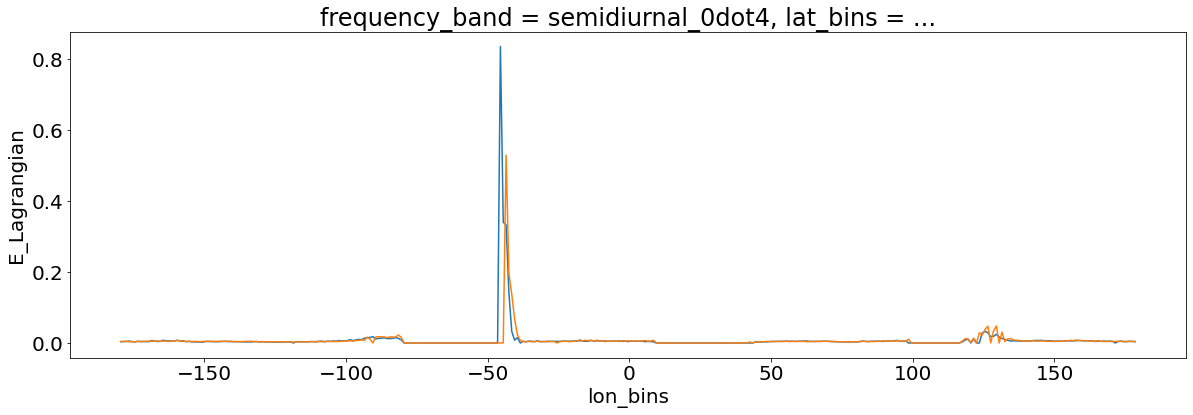

In [72]:
fig, ax = plt.subplots(figsize=(20,6))
ax = plt.subplot(111)
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4').sel(lat_bins=0.5).plot()
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4').sel(lat_bins=-0.5).plot()

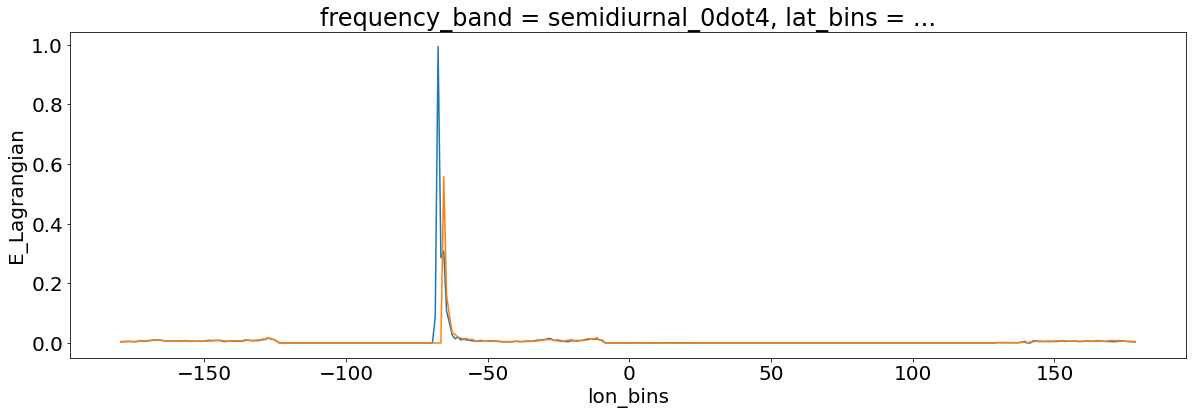

In [73]:
fig, ax = plt.subplots(figsize=(20,6))
ax = plt.subplot(111)
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4').sel(lat_bins=40.5).plot()
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4').sel(lat_bins=41.5).plot()

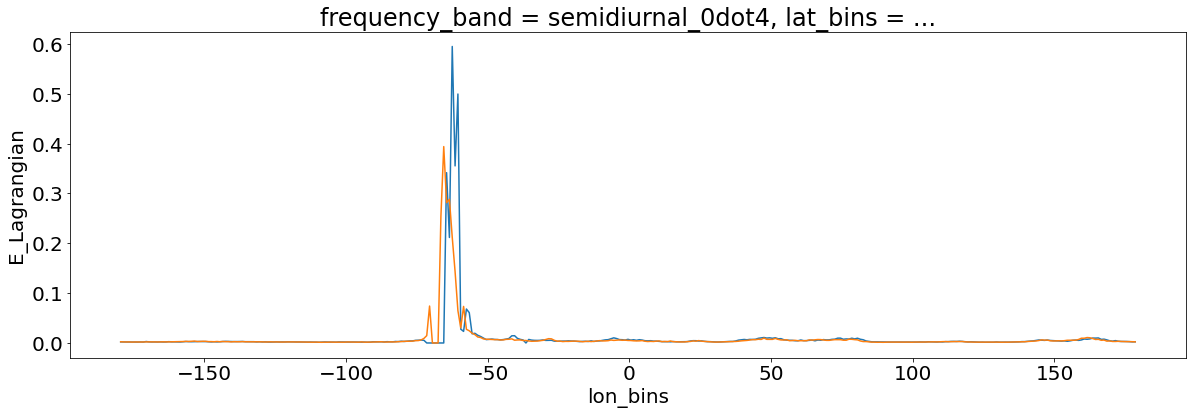

In [75]:
fig, ax = plt.subplots(figsize=(20,6))
ax = plt.subplot(111)
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4').sel(lat_bins=-54.5).plot()
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4').sel(lat_bins=-55.5).plot()

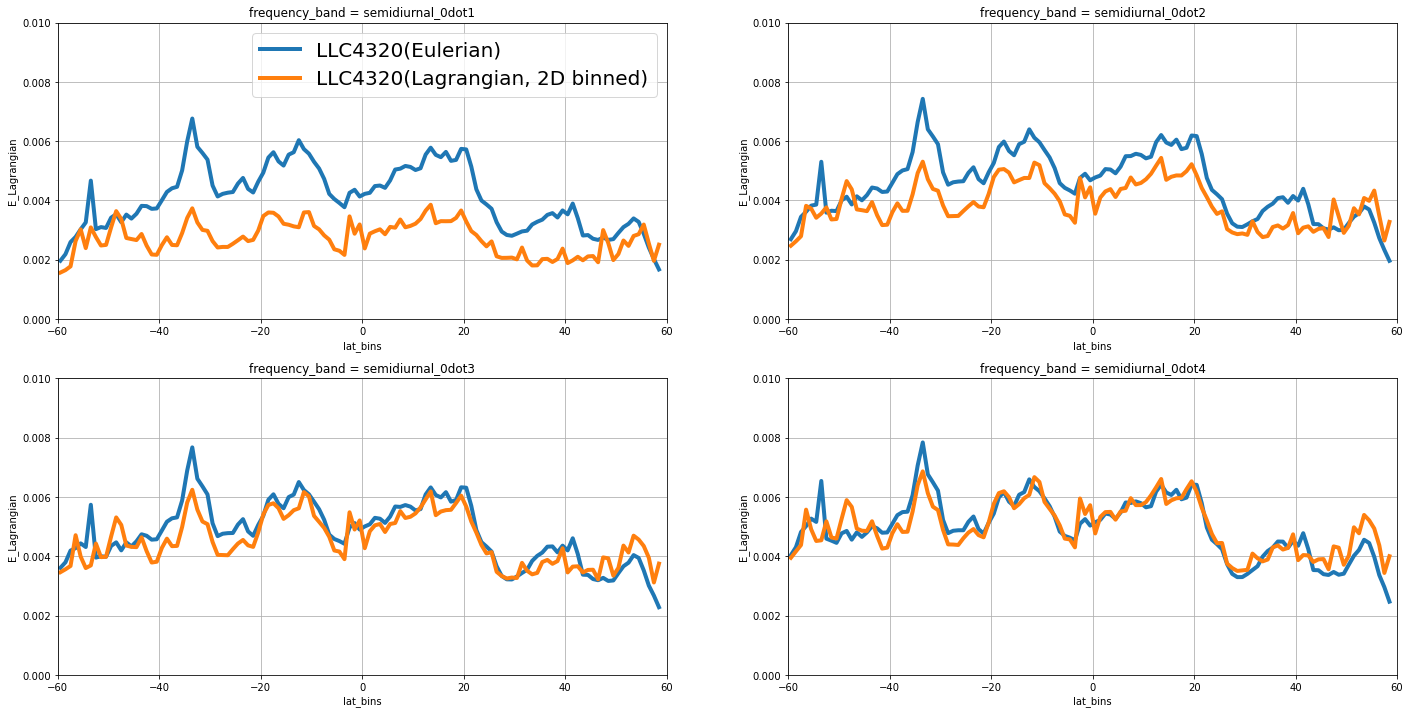

In [34]:
upper_limit = 0.2
labels = ['LLC4320(Eulerian)', 'LLC4320(Lagrangian, 2D binned)']

fig, ax = plt.subplots(figsize=(24,12))

ax = plt.subplot(221)
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').plot(label=labels[0], linewidth=4)
L_semi = ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1')
L_semi.where(L_semi<upper_limit).mean('lon_bins').plot(label=labels[1], linewidth=4)
ax.set_xlim(-60,60); ax.set_ylim(0., 0.01); ax.grid()
ax.legend(prop={'size': 20}); 

ax = plt.subplot(222)
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot2').mean('lon_bins').plot(linewidth=4)
L_semi = ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot2')
L_semi.where(L_semi<upper_limit).mean('lon_bins').plot(linewidth=4)
ax.set_xlim(-60,60); ax.set_ylim(0., 0.01); ax.grid()

ax = plt.subplot(223)
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot3').mean('lon_bins').plot(linewidth=4)
L_semi = ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot3')
L_semi.where(L_semi<upper_limit).mean('lon_bins').plot(linewidth=4)
ax.set_xlim(-60,60); ax.set_ylim(0., 0.01); ax.grid()

ax = plt.subplot(224)
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').plot(linewidth=4)
L_semi = ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4')
L_semi.where(L_semi<upper_limit).mean('lon_bins').plot(linewidth=4)
ax.set_xlim(-60,60); ax.set_ylim(0., 0.01); ax.grid()

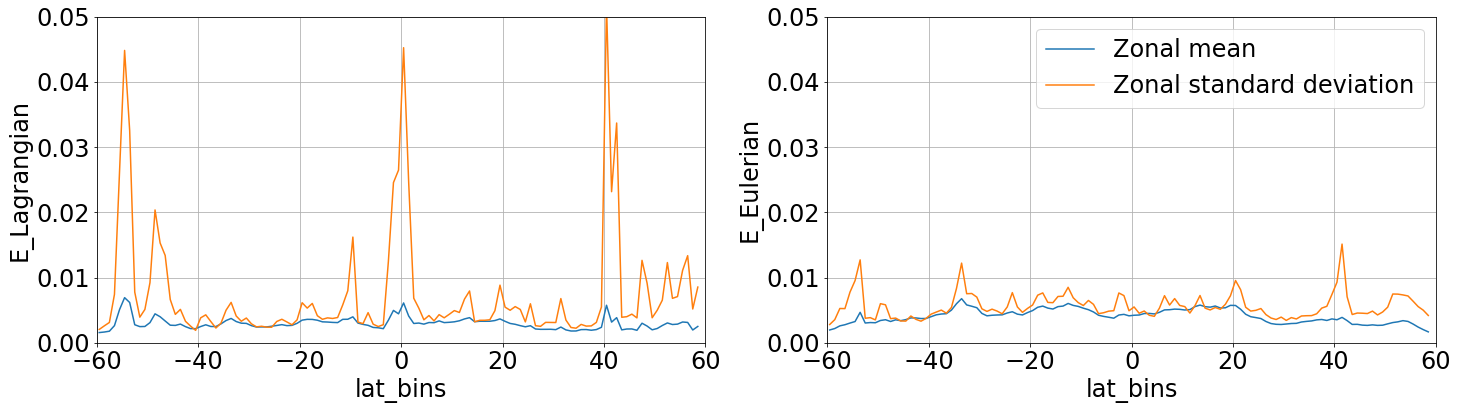

In [21]:
labels = ['Zonal mean', 'Zonal standard deviation']


L_semi = ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4')
fig, ax = plt.subplots(figsize=(24,6))

ax = plt.subplot(121)
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').plot(label=labels[0])
ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot1').std('lon_bins').plot(label=labels[1])
ax.set_title('',fontsize=24)
ax.set_xlim(-60., 60.)
ax.set_ylim(0., 0.05)
ax.grid()

ax = plt.subplot(122)
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').plot(label=labels[0])
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1').std('lon_bins').plot(label=labels[1])
ax.set_title('',fontsize=24)
ax.set_xlim(-60., 60.)
ax.set_ylim(0., 0.05)
ax.grid()
ax.legend(prop={'size': 24}); 


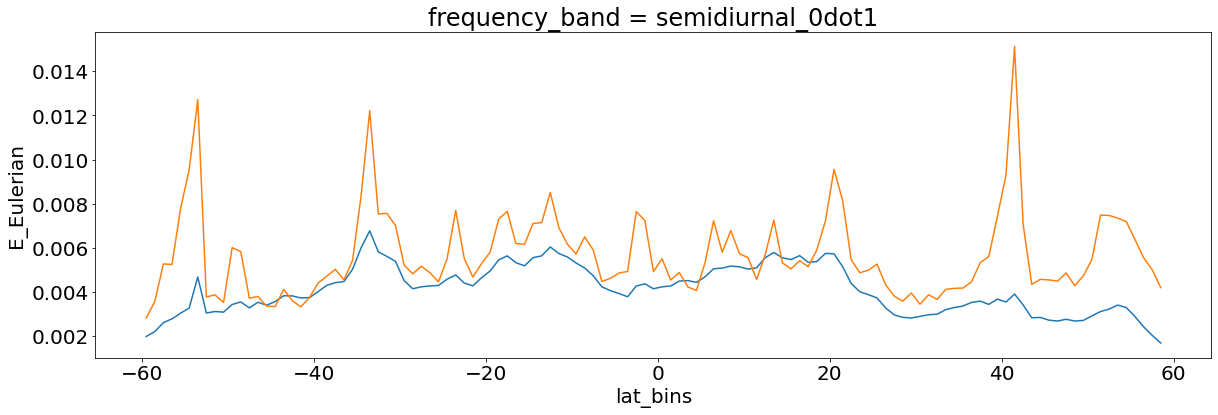

In [77]:
L_semi = ds_E.E_Lagrangian.sel(frequency_band='semidiurnal_0dot4')
fig, ax = plt.subplots(figsize=(20,6))
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').plot()
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1').std('lon_bins').plot()

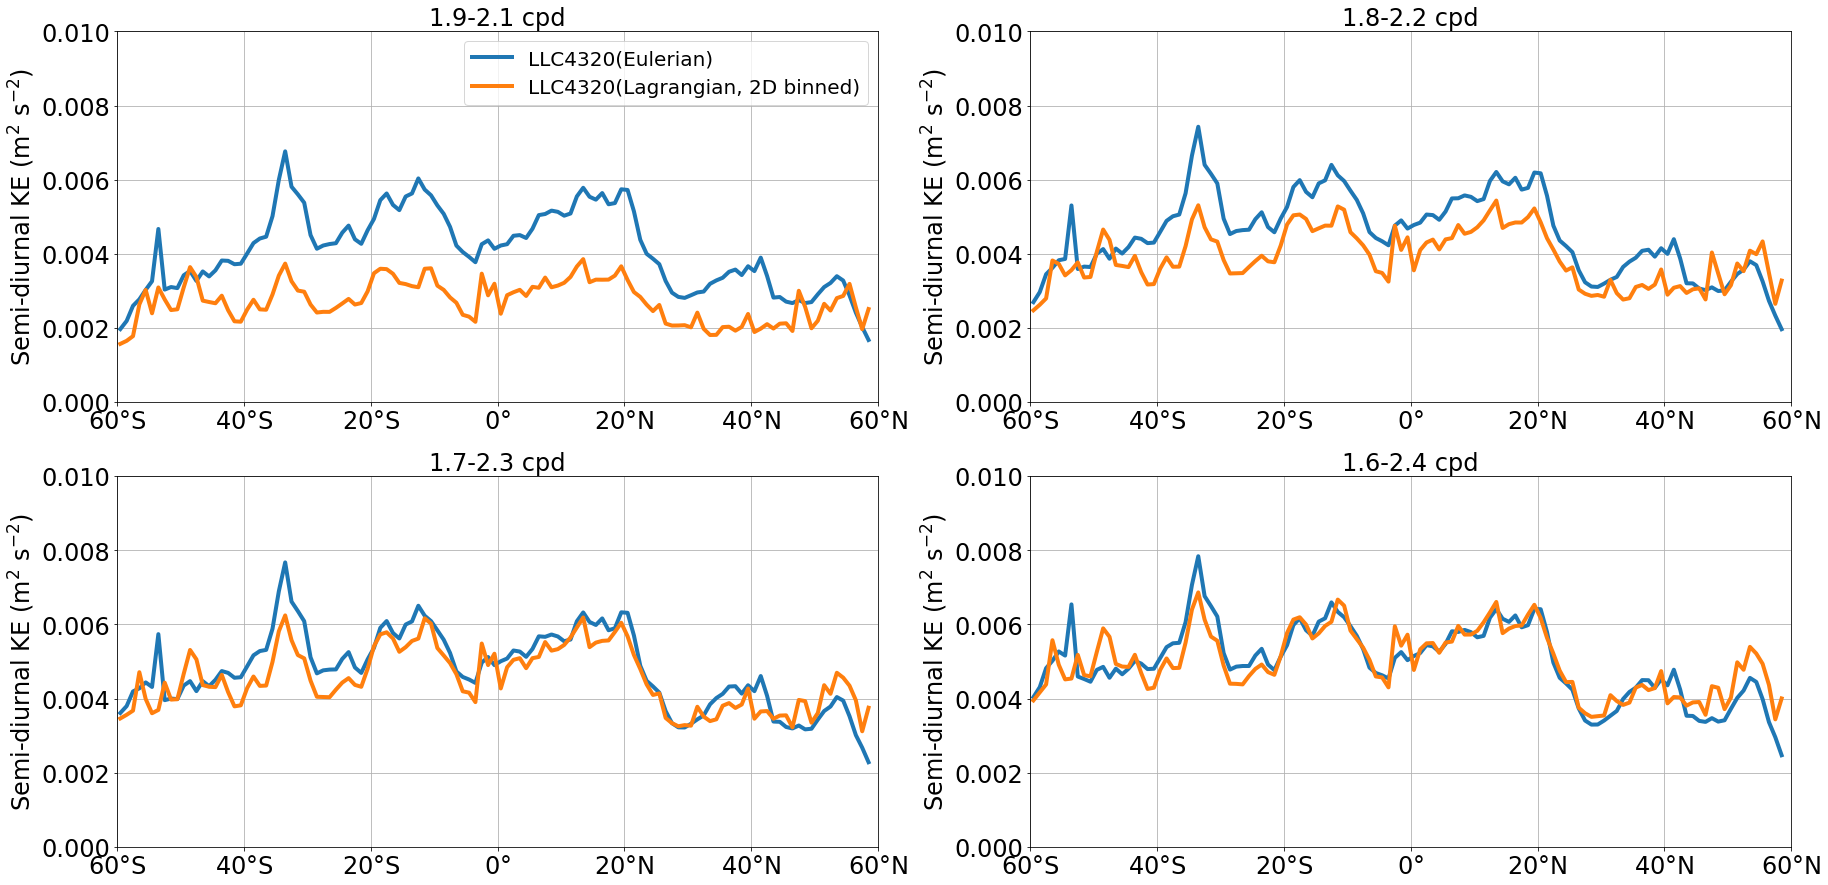

In [33]:
upper_limit = 0.2
labels = ['LLC4320(Eulerian)', 'LLC4320(Lagrangian, 2D binned)']

fig, ax = plt.subplots(figsize=(30,15))

ax = plt.subplot(2,2,1)
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').plot(color='tab:blue', label=labels[0], linewidth=4)
ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).sel(frequency_band='semidiurnal_0dot1').mean('lon_bins').plot(color='tab:orange', label=labels[1], linewidth=4)
ax.legend(prop={'size': 20}); 
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.01])
# Label, size
ax.set_xlabel('',fontsize=24)
ax.set_ylabel('Semi-diurnal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('1.9-2.1 cpd',fontsize=24)

ax = plt.subplot(2,2,2)
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot2').mean('lon_bins').plot(color='tab:blue', label=labels[0], linewidth=4)
ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).sel(frequency_band='semidiurnal_0dot2').mean('lon_bins').plot(color='tab:orange', label=labels[1], linewidth=4)
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.01])
# Label, size
ax.set_xlabel('',fontsize=24)
ax.set_ylabel('Semi-diurnal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('1.8-2.2 cpd',fontsize=24)

ax = plt.subplot(2,2,3)
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot3').mean('lon_bins').plot(color='tab:blue', label=labels[0], linewidth=4)
ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).sel(frequency_band='semidiurnal_0dot3').mean('lon_bins').plot(color='tab:orange', label=labels[1], linewidth=4)
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.01])
# Label, size
ax.set_xlabel('',fontsize=24)
ax.set_ylabel('Semi-diurnal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('1.7-2.3 cpd',fontsize=24)


ax = plt.subplot(2,2,4)
ds_E.E_Eulerian.sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').plot(color='tab:blue', label=labels[0], linewidth=4)
ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).sel(frequency_band='semidiurnal_0dot4').mean('lon_bins').plot(color='tab:orange', label=labels[1], linewidth=4)
ax.grid()
# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylim([0,0.01])
# Label, size
ax.set_xlabel('',fontsize=24)
ax.set_ylabel('Semi-diurnal KE (m$^2$ s$^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('1.6-2.4 cpd',fontsize=24)


plt.savefig('/home1/datahome/xyu/equinox_working/Lagrangian_vs_Eulerian_LLC4320/Figures/Band_integral_LLC_Eulerian_Lagrangian_bandwidth_semidiurnal_improved.png')

## Close cluster

In [25]:
cluster.close()